# Import dependencies

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from utils.data.load_root import load_root
from utils.data.build_graph import build_graphs
from utils.data.load_graphs import load_graphs
from utils.evaluation.evaluate_graphs import evaluate_data, evaluate_graphs
from utils.plotting.plot_events import plot_information, plot_event
from utils.data.graphdata import GraphDataset
from utils.models.interaction_network import InteractionNetwork
from utils.training.train_3 import train_model
from utils.evaluation.evaluate_model import evaluate_model


# Import Root data

In [2]:
%%time
load_rootdata = False

if load_rootdata:
    path = "~/Documents/Masterarbeit/Panda_Software/PandaRoot/dev/source/macro/data/evtcomplete"
    raw = load_root(path, showentries=True)
    raw.to_hdf('data/raw.h5', key='df', mode='w')  

else:
    raw = pd.read_hdf('data/raw.h5', 'df')  

CPU times: user 143 ms, sys: 135 ms, total: 277 ms
Wall time: 276 ms


Choose number of events to be analysed

In [3]:
nevents = raw.index.max()
nevents = 100
node_dim = 3
edge_dim = 3

# Investigate raw data

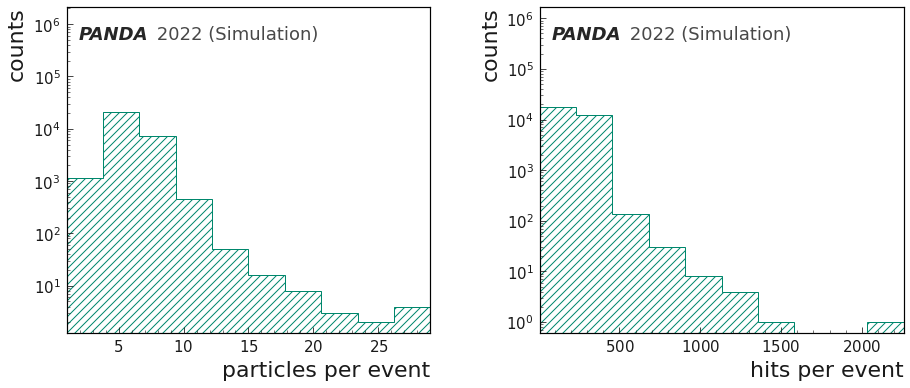

mean number of particles: 5.806633333333333, mean number of hits: 220.64846666666668


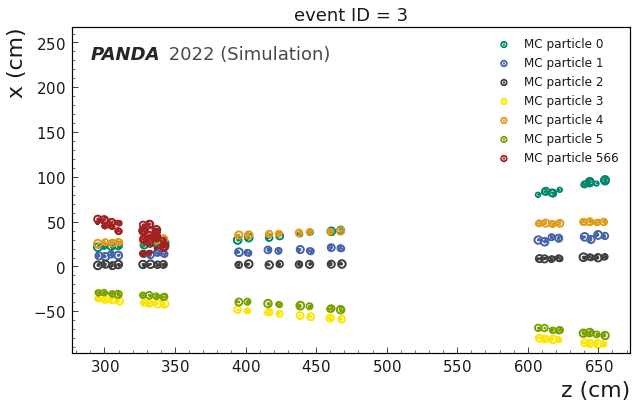

CPU times: user 3.04 s, sys: 1.24 s, total: 4.28 s
Wall time: 2.81 s


In [4]:
%%time

show=True
if show:
   
    plot_information(raw).plot_ntracks_nhits()
    evID=np.random.randint(nevents)
    evID = 3
    event = raw.loc[raw.index==evID]
    plot_event(event, scale=1.8).plot_eventdisplay()
    
#     data_eval = evaluate_data(raw, ncuts=50)
#     data_eval.plot_pzcut()
#     data_eval.curler_dist()

# Graph building for training

In [5]:
%%time
dir = 'data/graphs'
data = build_graphs(raw,end=nevents, shuffle=True, remove_duplicates=True)
create_g = False

if create_g:
    graphs = data.create_graph_list()
    targets = []


    for f in os.listdir(dir):
        os.remove(os.path.join(dir, f))

    for graph in graphs:
        evID = graph.pid.index.unique()[0]
        x, edge_attr, edge_index, y, pid = graph
        x = x[:,:node_dim]
        edge_attr = edge_attr[:edge_dim,:]
        targets.append(y)
        arr = np.asanyarray([x, edge_attr, edge_index, y, pid], dtype=object)
        np.save(f'{dir}/graph_{evID}.npy', arr)
    print(f'graphs saved to {dir}')

    targets = np.concatenate(targets)
    print(f'signal fraction true/all edges: {np.sum(targets)/len(targets)}')

graphs = load_graphs(dir, nevents, node_dim, edge_dim)

#show preprocessed data
data.events.sort_index()

CPU times: user 70.3 ms, sys: 338 µs, total: 70.7 ms
Wall time: 69.8 ms


hit_id           x           z       iso        pz  chamber_id  \
event_id                                                                   
0          20289   27.522499  309.390015  0.381878  3.068213           1   
0           7041   70.952499  653.489990  0.451314  7.614493           6   
0            891   27.522499  437.489990  0.119575  2.421842           4   
0          15646   20.452499  341.390015  0.382967  2.431979           2   
0          10554   29.037500  327.769684  0.322732  3.068082           2   
...          ...         ...         ...       ...       ...         ...   
100         4609 -102.767502  653.489990  0.059770  9.606862           6   
100          886    8.332500  437.489990  0.393287  8.433346           4   
100        13785   44.187500  327.769684  0.099623  3.149890           2   
100         4338   70.952499  621.489990  0.421694  2.159626           5   
100        20797   39.642502  294.894989  0.054772  3.149961           1   

          skewed  particle_id  layer_id  Hit_id  layer           r     theta  
event_id                                                                      
0              0            1         7     155      3  310.611766  0.088724  
0              0            2        47     147     23  657.330529  0.108151  
0              0            0        25     221     13  438.354856  0.062827  
0              0            0        15     211      7  342.002115  0.059838  
0              0            1        10     158      6  329.053403  0.088360  
...          ...          ...       ...     ...    ...         ...       ...  
100            0            0        47     239     23  661.521222 -0.155982  
100            0            3        25     121     13  437.569334  0.019044  
100            0            5        10       9      6  330.734789  0.134005  
100            0            2        39     183     19  625.527030  0.113673  
100            0            5         1       0      1  297.547614  0.133628  

[10522 rows x 13 columns]

# Evaluate Graph building
for comparison with original raw data choose evaluate_graphs(data.raw.rename(columns={'layer_id':'layer'}), graphs).evaluate_graphs()

In [6]:
%%time
evaluate_gb = False

if evaluate_gb:
    slope = np.linspace(0.1,4,20)
    testdata = build_graphs(raw,end=100, shuffle=True, remove_duplicates=True)

    purities, efficiencies = np.zeros(len(slope)), np.zeros(len(slope))

    for i, s in enumerate(tqdm(slope)):
        testdata.slope = s
        testgraphs = testdata.create_graph_list(show_progress=False)
        purity, efficiency, _ = evaluate_graphs(testdata.events, testgraphs).evaluate_graphs(show_progress=False)
        purities[i] = np.mean(purity)
        efficiencies[i] = np.mean(efficiency)


    plot_information().plot_purity_efficiency(slope, 3, purities, efficiencies, 'slope cut', 'graph building', 'img/graphbuilding_purity_efficiency.pdf')

    plot_information(graphs=graphs).plot_graph_information()

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.15 µs


# Plot Graphs

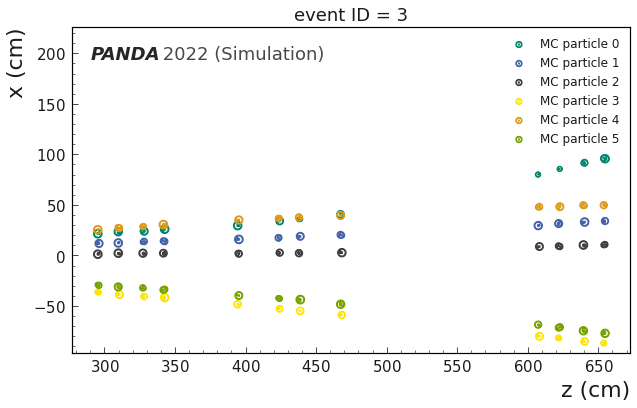

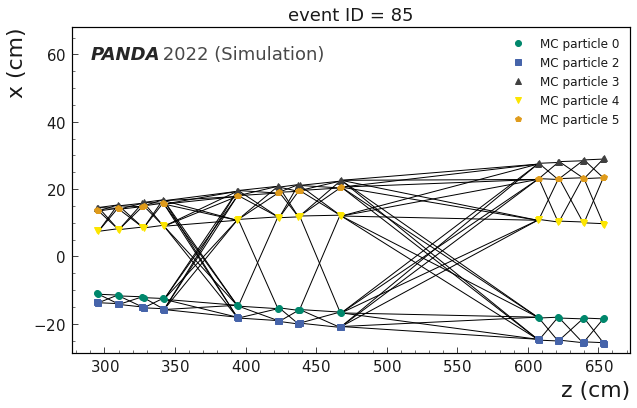

CPU times: user 1.31 s, sys: 272 ms, total: 1.58 s
Wall time: 1.29 s


In [7]:
%%time
evID = np.random.randint(nevents)
evID = 3

hits = data.events.loc[evID]
graph = graphs[evID]

plotevent = plot_event(hits, graph=graph , shift=.12, scale=1.6)
plotevent.plot_eventdisplay()
plotevent.plot_graphdisplay()




# Prepare Training

In [29]:
# torch.manual_seed(42)
device = 'cpu'
hidden_size = 6
name = f'IN_trained_events_{nevents}_neurons_{hidden_size}'
lr = 0.026537289771774733
gamma = 0.7007247907630494
epochs = 50
patience = 10
step_size = 4
batch_size = 1


parts = [0.8, 0.1, 0.1] #sizes of training, validation and testing samples
load_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 8}

In [30]:
parts = np.cumsum((nevents*np.array(parts)).astype(int))
partition = {'train': graphs[:parts[0]],  
             'test':  graphs[parts[0]:parts[1]],
             'val': graphs[parts[1]:parts[2]]}


train_set = GraphDataset(partition['train'])
train_loader = DataLoader(train_set, **load_params)
test_set = GraphDataset(partition['test'])
test_loader = DataLoader(test_set, **load_params)
val_set = GraphDataset(partition['val'])
val_loader = DataLoader(val_set, **load_params)

In [31]:
model = InteractionNetwork(hidden_size=hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

model.count_parameters()

InteractionNetwork(node_dim: 3, edge_dim: 3, hidden_size: 6)
+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| R1.layers.0.weight |     54     |
|  R1.layers.0.bias  |     6      |
| R1.layers.2.weight |     36     |
|  R1.layers.2.bias  |     6      |
| R1.layers.4.weight |     18     |
|  R1.layers.4.bias  |     3      |
| O.layers.0.weight  |     36     |
|  O.layers.0.bias   |     6      |
| O.layers.2.weight  |     36     |
|  O.layers.2.bias   |     6      |
| O.layers.4.weight  |     18     |
|  O.layers.4.bias   |     3      |
| R2.layers.0.weight |     54     |
|  R2.layers.0.bias  |     6      |
| R2.layers.2.weight |     36     |
|  R2.layers.2.bias  |     6      |
| R2.layers.4.weight |     6      |
|  R2.layers.4.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 337


# Training

In [32]:
results = train_model(train_loader, val_loader, model, optimizer, scheduler, epochs=epochs, patience=patience, name=name)

  0%|                                                    | 0/50 [00:00<?, ?it/s]

Train Epoch: 1, epoch time: 0.67s
Mean Train Batch Loss: 0.4985


  2%|▉                                           | 1/50 [00:00<00:43,  1.13it/s]


 Validation set: Average loss: 0.0422
, Accuracy: 0.8751

Validation loss decreased (inf --> 0.328246).  Saving model ...
Train Epoch: 2, epoch time: 0.70s
Mean Train Batch Loss: 0.3430


  4%|█▊                                          | 2/50 [00:01<00:43,  1.10it/s]


 Validation set: Average loss: 0.0374
, Accuracy: 0.8790

EarlyStopping counter: 1 out of 10
Train Epoch: 3, epoch time: 0.69s
Mean Train Batch Loss: 0.3095


  6%|██▋                                         | 3/50 [00:02<00:43,  1.09it/s]


 Validation set: Average loss: 0.0629
, Accuracy: 0.8725

EarlyStopping counter: 2 out of 10
Train Epoch: 4, epoch time: 0.68s
Mean Train Batch Loss: 0.2891


  8%|███▌                                        | 4/50 [00:03<00:42,  1.09it/s]


 Validation set: Average loss: 0.0086
, Accuracy: 0.9205

Validation loss decreased (0.328246 --> 0.225227).  Saving model ...
Train Epoch: 5, epoch time: 0.70s
Mean Train Batch Loss: 0.2464


 10%|████▍                                       | 5/50 [00:04<00:41,  1.08it/s]


 Validation set: Average loss: 0.0138
, Accuracy: 0.9343

Validation loss decreased (0.225227 --> 0.204466).  Saving model ...
Train Epoch: 6, epoch time: 0.68s
Mean Train Batch Loss: 0.2339


 12%|█████▎                                      | 6/50 [00:05<00:40,  1.08it/s]


 Validation set: Average loss: 0.0205
, Accuracy: 0.9136

EarlyStopping counter: 1 out of 10
Train Epoch: 7, epoch time: 0.68s
Mean Train Batch Loss: 0.2222


 14%|██████▏                                     | 7/50 [00:06<00:39,  1.10it/s]


 Validation set: Average loss: 0.0215
, Accuracy: 0.9347

Validation loss decreased (0.204466 --> 0.195863).  Saving model ...
Train Epoch: 8, epoch time: 0.66s
Mean Train Batch Loss: 0.2273


 16%|███████                                     | 8/50 [00:07<00:37,  1.12it/s]


 Validation set: Average loss: 0.0045
, Accuracy: 0.9330

EarlyStopping counter: 1 out of 10
Train Epoch: 9, epoch time: 0.70s
Mean Train Batch Loss: 0.2106


 18%|███████▉                                    | 9/50 [00:08<00:37,  1.11it/s]


 Validation set: Average loss: 0.0498
, Accuracy: 0.9399

Validation loss decreased (0.195863 --> 0.191741).  Saving model ...
Train Epoch: 10, epoch time: 0.64s
Mean Train Batch Loss: 0.2108


 20%|████████▌                                  | 10/50 [00:09<00:35,  1.13it/s]


 Validation set: Average loss: 0.0107
, Accuracy: 0.9270

EarlyStopping counter: 1 out of 10
Train Epoch: 11, epoch time: 0.85s
Mean Train Batch Loss: 0.1980


 22%|█████████▍                                 | 11/50 [00:10<00:36,  1.06it/s]


 Validation set: Average loss: 0.0244
, Accuracy: 0.9447

Validation loss decreased (0.191741 --> 0.171199).  Saving model ...
Train Epoch: 12, epoch time: 0.68s
Mean Train Batch Loss: 0.1960


 24%|██████████▎                                | 12/50 [00:11<00:35,  1.08it/s]


 Validation set: Average loss: 0.0030
, Accuracy: 0.9192

EarlyStopping counter: 1 out of 10
Train Epoch: 13, epoch time: 0.66s
Mean Train Batch Loss: 0.1911


 26%|███████████▏                               | 13/50 [00:11<00:33,  1.09it/s]


 Validation set: Average loss: 0.0081
, Accuracy: 0.9468

Validation loss decreased (0.171199 --> 0.168418).  Saving model ...
Train Epoch: 14, epoch time: 0.70s
Mean Train Batch Loss: 0.1815


 28%|████████████                               | 14/50 [00:12<00:32,  1.10it/s]


 Validation set: Average loss: 0.0102
, Accuracy: 0.9460

Validation loss decreased (0.168418 --> 0.166910).  Saving model ...
Train Epoch: 15, epoch time: 0.67s
Mean Train Batch Loss: 0.1813


 30%|████████████▉                              | 15/50 [00:13<00:31,  1.10it/s]


 Validation set: Average loss: 0.0075
, Accuracy: 0.9486

Validation loss decreased (0.166910 --> 0.159725).  Saving model ...
Train Epoch: 16, epoch time: 0.64s
Mean Train Batch Loss: 0.1733


 32%|█████████████▊                             | 16/50 [00:14<00:30,  1.11it/s]


 Validation set: Average loss: 0.0254
, Accuracy: 0.9447

EarlyStopping counter: 1 out of 10
Train Epoch: 17, epoch time: 0.64s
Mean Train Batch Loss: 0.1720


 34%|██████████████▌                            | 17/50 [00:15<00:29,  1.12it/s]


 Validation set: Average loss: 0.0071
, Accuracy: 0.9434

EarlyStopping counter: 2 out of 10
Train Epoch: 18, epoch time: 0.63s
Mean Train Batch Loss: 0.1702


 36%|███████████████▍                           | 18/50 [00:16<00:28,  1.14it/s]


 Validation set: Average loss: 0.0196
, Accuracy: 0.9455

Validation loss decreased (0.159725 --> 0.150260).  Saving model ...
Train Epoch: 19, epoch time: 0.69s
Mean Train Batch Loss: 0.1696


 38%|████████████████▎                          | 19/50 [00:17<00:27,  1.13it/s]


 Validation set: Average loss: 0.0083
, Accuracy: 0.9309

EarlyStopping counter: 1 out of 10
Train Epoch: 20, epoch time: 0.66s
Mean Train Batch Loss: 0.1763


 40%|█████████████████▏                         | 20/50 [00:18<00:26,  1.13it/s]


 Validation set: Average loss: 0.0063
, Accuracy: 0.9455

EarlyStopping counter: 2 out of 10
Train Epoch: 21, epoch time: 0.67s
Mean Train Batch Loss: 0.1660


 42%|██████████████████                         | 21/50 [00:18<00:25,  1.12it/s]


 Validation set: Average loss: 0.0070
, Accuracy: 0.9455

EarlyStopping counter: 3 out of 10
Train Epoch: 22, epoch time: 0.69s
Mean Train Batch Loss: 0.1673


 44%|██████████████████▉                        | 22/50 [00:19<00:25,  1.11it/s]


 Validation set: Average loss: 0.0041
, Accuracy: 0.9481

EarlyStopping counter: 4 out of 10
Train Epoch: 23, epoch time: 0.67s
Mean Train Batch Loss: 0.1659


 46%|███████████████████▊                       | 23/50 [00:20<00:24,  1.12it/s]


 Validation set: Average loss: 0.0223
, Accuracy: 0.9499

Validation loss decreased (0.150260 --> 0.149665).  Saving model ...
Train Epoch: 24, epoch time: 0.66s
Mean Train Batch Loss: 0.1643


 48%|████████████████████▋                      | 24/50 [00:21<00:23,  1.12it/s]


 Validation set: Average loss: 0.0186
, Accuracy: 0.9447

EarlyStopping counter: 1 out of 10
Train Epoch: 25, epoch time: 0.65s
Mean Train Batch Loss: 0.1627


 50%|█████████████████████▌                     | 25/50 [00:22<00:22,  1.14it/s]


 Validation set: Average loss: 0.0193
, Accuracy: 0.9503

Validation loss decreased (0.149665 --> 0.145479).  Saving model ...
Train Epoch: 26, epoch time: 0.66s
Mean Train Batch Loss: 0.1621


 52%|██████████████████████▎                    | 26/50 [00:23<00:21,  1.14it/s]


 Validation set: Average loss: 0.0043
, Accuracy: 0.9473

EarlyStopping counter: 1 out of 10
Train Epoch: 27, epoch time: 0.66s
Mean Train Batch Loss: 0.1641


 54%|███████████████████████▏                   | 27/50 [00:24<00:20,  1.13it/s]


 Validation set: Average loss: 0.0177
, Accuracy: 0.9443

EarlyStopping counter: 2 out of 10
Train Epoch: 28, epoch time: 0.63s
Mean Train Batch Loss: 0.1618


 56%|████████████████████████                   | 28/50 [00:25<00:19,  1.15it/s]


 Validation set: Average loss: 0.0205
, Accuracy: 0.9408

EarlyStopping counter: 3 out of 10
Train Epoch: 29, epoch time: 0.68s
Mean Train Batch Loss: 0.1618


 58%|████████████████████████▉                  | 29/50 [00:26<00:18,  1.14it/s]


 Validation set: Average loss: 0.0190
, Accuracy: 0.9481

Validation loss decreased (0.145479 --> 0.144988).  Saving model ...
Train Epoch: 30, epoch time: 0.65s
Mean Train Batch Loss: 0.1587


 60%|█████████████████████████▊                 | 30/50 [00:26<00:17,  1.14it/s]


 Validation set: Average loss: 0.0058
, Accuracy: 0.9490

Validation loss decreased (0.144988 --> 0.144207).  Saving model ...
Train Epoch: 31, epoch time: 0.69s
Mean Train Batch Loss: 0.1598


 62%|██████████████████████████▋                | 31/50 [00:27<00:16,  1.13it/s]


 Validation set: Average loss: 0.0062
, Accuracy: 0.9520

Validation loss decreased (0.144207 --> 0.143499).  Saving model ...
Train Epoch: 32, epoch time: 0.63s
Mean Train Batch Loss: 0.1593


 64%|███████████████████████████▌               | 32/50 [00:28<00:16,  1.12it/s]


 Validation set: Average loss: 0.0066
, Accuracy: 0.9512

EarlyStopping counter: 1 out of 10
Train Epoch: 33, epoch time: 0.69s
Mean Train Batch Loss: 0.1585


 66%|████████████████████████████▍              | 33/50 [00:29<00:15,  1.11it/s]


 Validation set: Average loss: 0.0241
, Accuracy: 0.9481

EarlyStopping counter: 2 out of 10
Train Epoch: 34, epoch time: 0.64s
Mean Train Batch Loss: 0.1579


 68%|█████████████████████████████▏             | 34/50 [00:30<00:14,  1.12it/s]


 Validation set: Average loss: 0.0055
, Accuracy: 0.9477

EarlyStopping counter: 3 out of 10
Train Epoch: 35, epoch time: 0.69s
Mean Train Batch Loss: 0.1573


 70%|██████████████████████████████             | 35/50 [00:31<00:13,  1.11it/s]


 Validation set: Average loss: 0.0035
, Accuracy: 0.9499

Validation loss decreased (0.143499 --> 0.142110).  Saving model ...
Train Epoch: 36, epoch time: 0.68s
Mean Train Batch Loss: 0.1572


 72%|██████████████████████████████▉            | 36/50 [00:32<00:12,  1.12it/s]


 Validation set: Average loss: 0.0038
, Accuracy: 0.9460

EarlyStopping counter: 1 out of 10
Train Epoch: 37, epoch time: 0.69s
Mean Train Batch Loss: 0.1568


 74%|███████████████████████████████▊           | 37/50 [00:33<00:11,  1.11it/s]


 Validation set: Average loss: 0.0198
, Accuracy: 0.9490

EarlyStopping counter: 2 out of 10
Train Epoch: 38, epoch time: 0.64s
Mean Train Batch Loss: 0.1557


 76%|████████████████████████████████▋          | 38/50 [00:34<00:10,  1.11it/s]


 Validation set: Average loss: 0.0062
, Accuracy: 0.9499

Validation loss decreased (0.142110 --> 0.141774).  Saving model ...
Train Epoch: 39, epoch time: 0.69s
Mean Train Batch Loss: 0.1564


 78%|█████████████████████████████████▌         | 39/50 [00:35<00:10,  1.10it/s]


 Validation set: Average loss: 0.0326
, Accuracy: 0.9443

EarlyStopping counter: 1 out of 10
Train Epoch: 40, epoch time: 0.70s
Mean Train Batch Loss: 0.1566


 80%|██████████████████████████████████▍        | 40/50 [00:35<00:09,  1.10it/s]


 Validation set: Average loss: 0.0053
, Accuracy: 0.9443

EarlyStopping counter: 2 out of 10
Train Epoch: 41, epoch time: 0.69s
Mean Train Batch Loss: 0.1540


 82%|███████████████████████████████████▎       | 41/50 [00:36<00:08,  1.10it/s]


 Validation set: Average loss: 0.0058
, Accuracy: 0.9490

EarlyStopping counter: 3 out of 10
Train Epoch: 42, epoch time: 0.66s
Mean Train Batch Loss: 0.1557


 84%|████████████████████████████████████       | 42/50 [00:37<00:07,  1.12it/s]


 Validation set: Average loss: 0.0084
, Accuracy: 0.9468

EarlyStopping counter: 4 out of 10
Train Epoch: 43, epoch time: 0.67s
Mean Train Batch Loss: 0.1549


 86%|████████████████████████████████████▉      | 43/50 [00:38<00:06,  1.12it/s]


 Validation set: Average loss: 0.0225
, Accuracy: 0.9494

EarlyStopping counter: 5 out of 10
Train Epoch: 44, epoch time: 0.65s
Mean Train Batch Loss: 0.1554


 88%|█████████████████████████████████████▊     | 44/50 [00:39<00:05,  1.12it/s]


 Validation set: Average loss: 0.0216
, Accuracy: 0.9451

EarlyStopping counter: 6 out of 10
Train Epoch: 45, epoch time: 0.63s
Mean Train Batch Loss: 0.1550


 90%|██████████████████████████████████████▋    | 45/50 [00:40<00:04,  1.14it/s]


 Validation set: Average loss: 0.0086
, Accuracy: 0.9494

EarlyStopping counter: 7 out of 10
Train Epoch: 46, epoch time: 0.67s
Mean Train Batch Loss: 0.1553


 92%|███████████████████████████████████████▌   | 46/50 [00:41<00:03,  1.14it/s]


 Validation set: Average loss: 0.0058
, Accuracy: 0.9490

EarlyStopping counter: 8 out of 10
Train Epoch: 47, epoch time: 0.69s
Mean Train Batch Loss: 0.1544


 94%|████████████████████████████████████████▍  | 47/50 [00:42<00:02,  1.13it/s]


 Validation set: Average loss: 0.0052
, Accuracy: 0.9481

Validation loss decreased (0.141774 --> 0.141541).  Saving model ...
Train Epoch: 48, epoch time: 0.63s
Mean Train Batch Loss: 0.1548


 96%|█████████████████████████████████████████▎ | 48/50 [00:42<00:01,  1.14it/s]


 Validation set: Average loss: 0.0046
, Accuracy: 0.9486

Validation loss decreased (0.141541 --> 0.141363).  Saving model ...
Train Epoch: 49, epoch time: 0.66s
Mean Train Batch Loss: 0.1540


 98%|██████████████████████████████████████████▏| 49/50 [00:43<00:00,  1.14it/s]


 Validation set: Average loss: 0.0083
, Accuracy: 0.9503

Validation loss decreased (0.141363 --> 0.141341).  Saving model ...
Train Epoch: 50, epoch time: 0.67s
Mean Train Batch Loss: 0.1543


100%|███████████████████████████████████████████| 50/50 [00:44<00:00,  1.12it/s]


 Validation set: Average loss: 0.0057
, Accuracy: 0.9494

EarlyStopping counter: 1 out of 10


In [20]:
model, losses, accs, test_losses, test_accs = results.trained

# Evaluate Training

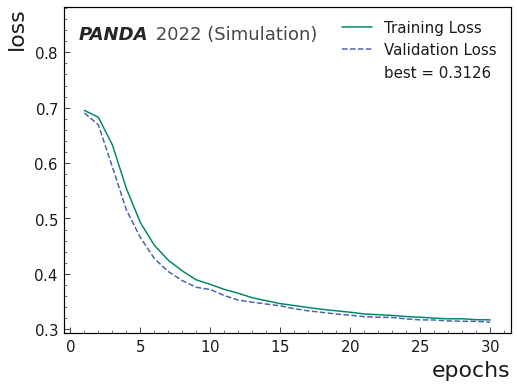

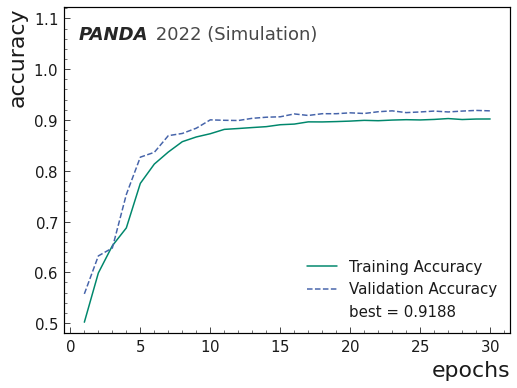

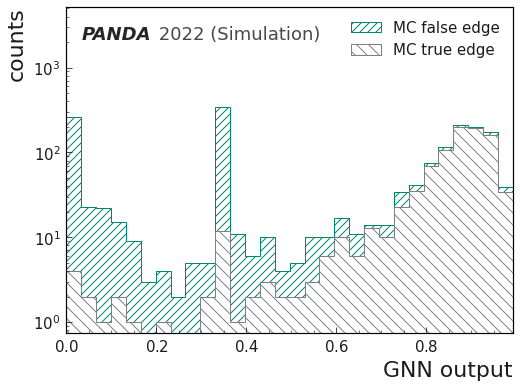

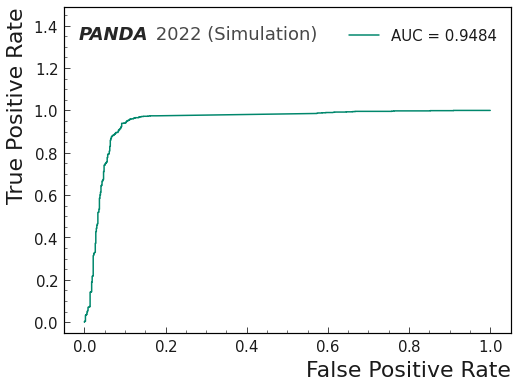

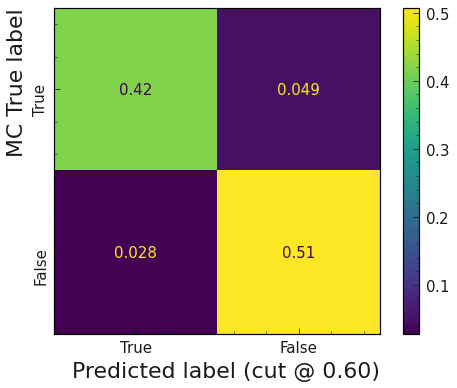

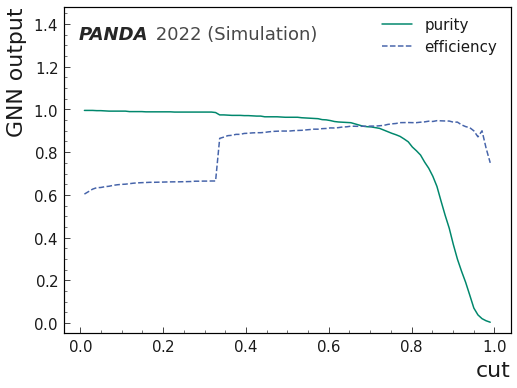

In [21]:
threshold = 0.6
evaluation = evaluate_model(model, test_loader, losses, test_losses, accs, test_accs, threshold, ncuts=100)
evaluation.plot_loss()
evaluation.plot_acc()
evaluation.plot_metrics()

# Show Results

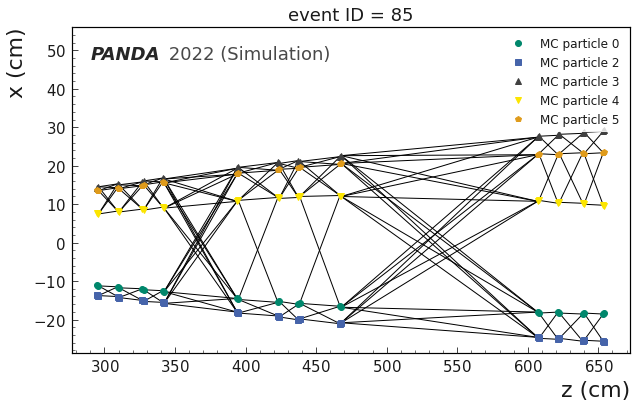

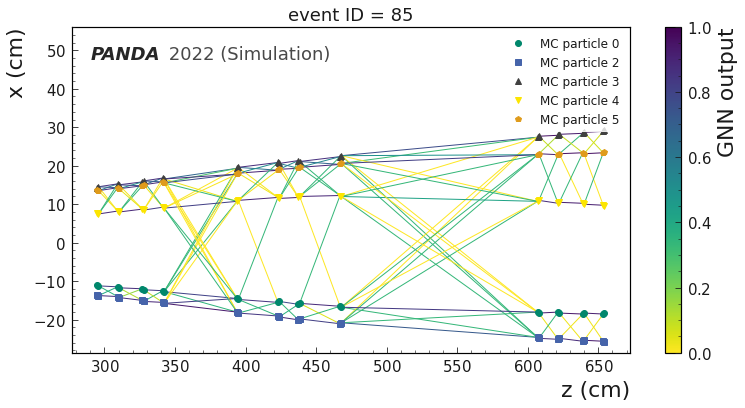

In [22]:
plot_event(hits, graph).plot_graphdisplay()
plot_event(hits, graph).plot_traineddisplay(model)